In [1]:
########################################## Pre-Training Generation & Check Script#############################################
import random
import pandas as pd

# List of metallic elements available with assigned weights
METALLIC_ELEMENTS_WEIGHTS = {
    "Li": 0.1, "Be": 0.1, "B": 0.1, "C": 0.1, "N": 0.1, "Mg": 0.1, "Al": 2, "Si": 0.3, "Sc": 0.1, "Ti": 1.7, "V": 1.1, 
    "Cr": 2.5, "Mn": 0.8, "Fe": 3, "Co": 2.3, "Ni": 2.8, "Cu": 1.5, "Zn": 0.1, "Y": 0.1, "Zr": 0.7, "Nb": 1, "Mo": 1.3, 
    "Pd": 0.5, "Ag": 0.2, "Sn": 0.1, "Te": 0.1, "Ba": 0.1, "Hf": 0.4, "Ta": 0.5, "W": 0.4, "Re": 0.3, "Au": 0.3
}

# Expand the list by weights and convert to a list of tuples for random.choices()
weighted_metallic_elements = [(element, weight) for element, weight in METALLIC_ELEMENTS_WEIGHTS.items()]

# Define how many compositions are needed for each type and count of elements
composition_distribution = {
    8: {'equimolar': 200, 'non_equimolar': 200},
    7: {'equimolar': 200, 'non_equimolar': 200},
    6: {'equimolar': 500, 'non_equimolar': 500},
    5: {'equimolar': 1000, 'non_equimolar': 1000},
    4: {'equimolar': 300, 'non_equimolar': 300},
    3: {'equimolar': 300, 'non_equimolar': 300},
    2: {'equimolar': 496, 'non_equimolar': 500}
}

def generate_random_composition(num_elements, equimolar=True):
    """
    Generate a random composition of 'num_elements' elements, equimolar or not,
    ensuring no duplicate elements.
    """
    elements = random.choices(
        [elem for elem, _ in weighted_metallic_elements], 
        weights=[weight for _, weight in weighted_metallic_elements],
        k=num_elements
    )
    while len(set(elements)) != len(elements):  # Ensure all elements are unique
        elements = random.choices(
            [elem for elem, _ in weighted_metallic_elements], 
            weights=[weight for _, weight in weighted_metallic_elements],
            k=num_elements
        )
    
    if equimolar:
        fractions = [1] * num_elements
    else:
        fractions = [round(random.uniform(0.1, 2), 2) for _ in range(num_elements)]
        while len(set(fractions)) == 1:  # Ensure non-equimolar by checking all fractions are not the same
            fractions = [round(random.uniform(0.1, 2), 2) for _ in range(num_elements)]

    # Create a sorted tuple to ensure unique compositions regardless of order
    composition_tuple = tuple(sorted((element, fraction) for element, fraction in zip(elements, fractions)))
    return composition_tuple

all_compositions = set()  # Using a set to handle uniqueness

# Generate the required number of compositions for each element count and type
for num_elements, types in composition_distribution.items():
    counts = {'equimolar': 0, 'non_equimolar': 0}
    while counts['equimolar'] < types['equimolar'] or counts['non_equimolar'] < types['non_equimolar']:
        equimolar = counts['equimolar'] < types['equimolar']
        composition = generate_random_composition(num_elements, equimolar=equimolar)
        if composition not in all_compositions:
            all_compositions.add(composition)
            counts['equimolar' if equimolar else 'non_equimolar'] += 1

# Converting set to list after all compositions are generated
unique_compositions = [" ".join(f"{elem}{frac}" for elem, frac in comp) for comp in all_compositions]

# Save to CSV
df = pd.DataFrame(unique_compositions, columns=['composition'])
df.to_csv('6K.csv', index=False)

print(f"{len(df)} unique compositions saved to 'tesK_compositions_controlled_unique.csv'")


5996 unique compositions saved to 'tesK_compositions_controlled_unique.csv'


   Element  Frequency
5       Fe       2571
2       Ni       2482
9       Cr       2309
16      Co       2240
0       Al       2092
15      Ti       1818
10      Cu       1678
1       Mo       1478
12       V       1349
7       Nb       1286
6       Mn       1118
23      Zr       1007
13      Pd        767
8       Ta        751
3        W        637
17      Hf        607
14      Re        497
11      Si        482
18      Au        451
21      Ag        320
29      Be        201
27       N        199
30      Te        196
26       Y        194
28      Ba        192
24       B        191
22      Li        189
31      Sn        187
4       Zn        184
25       C        178
20      Mg        177
19      Sc        164


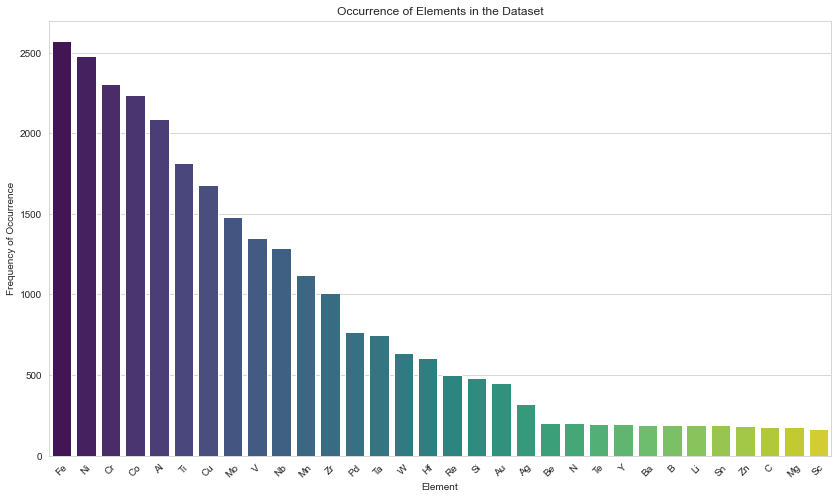

In [2]:
########################## Check Distribution#####################
import pandas as pd
from collections import Counter
import re

# Load dataset
data = pd.read_csv('6K.csv') #Phases.csv

def extract_elements(composition):
    # Extract elements, assume format is "ElementStoichiometry" like "Fe0.2"
    elements = re.findall(r'([A-Z][a-z]?)(?:[0-9.]+)', composition)
    return elements

# Extract elements from each composition and flatten the list
all_elements = [elem for sublist in data['composition'].map(extract_elements) for elem in sublist]

# Count occurrences of each element
element_frequency = Counter(all_elements)

# Convert to DataFrame for easier manipulation and plotting
element_df = pd.DataFrame(list(element_frequency.items()), columns=['Element', 'Frequency']).sort_values(by='Frequency', ascending=False)
print(element_df)


import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting the frequency of each element
plt.figure(figsize=(14, 8))
sns.barplot(data=element_df, x='Element', y='Frequency', palette='viridis')
plt.title('Occurrence of Elements in the Dataset')
plt.xlabel('Element')
plt.ylabel('Frequency of Occurrence')
plt.xticks(rotation=45)  # Rotate element names for better visibility
plt.show()




In [3]:
################################Check for any Duplicates #############################
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('6K.csv')

# Check for duplicate compositions
duplicate_compositions = df[df.duplicated(subset='composition', keep=False)]

if not duplicate_compositions.empty:
    print("Found duplicate compositions!")
    print(duplicate_compositions)
else:
    print("No duplicate compositions found.")
    

############################# Delete Dublicates and keep one instance ######################
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('6K.csv')

# Find duplicate compositions
duplicates = df[df.duplicated(subset='composition', keep=False)]

# For duplicated compositions, check if they have different phases
diff_phase_compositions = []

for composition in duplicates['composition'].unique():
    unique_phases = duplicates[duplicates['composition'] == composition]['hardness'].nunique()
    
    if unique_phases > 1:
        diff_phase_compositions.append(composition)

# Remove rows with compositions that have different phases
df = df[~df['composition'].isin(diff_phase_compositions)]

# Drop duplicates based on 'compositions' while keeping the first occurrence
df = df.drop_duplicates(subset='composition', keep='first')

# Save the cleaned dataframe back to a CSV
df.to_csv('6K.csv', index=False)


No duplicate compositions found.


In [10]:
########################################### Delete Zero Containing Rows #########################################

In [4]:
import pandas as pd

# Load your dataset
data = pd.read_csv('6K.csv')  # Replace 'your_dataset.csv' with your actual file path

# Define the columns to check for zeros (excluding 'composition')
columns_to_check = [col for col in data.columns if col != 'composition']

# Filter out rows where any of the specified columns contain zero
filtered_data = data[~(data[columns_to_check] == 0).any(axis=1)]

# Optionally, save the filtered dataset
filtered_data.to_csv('6K.csv', index=False)

# Print some information about the filtered dataset
print(filtered_data.head())
print(f"Original data size: {len(data)}, Filtered data size: {len(filtered_data)}")


                          composition
0    Al1.71 Mo0.3 Ni0.38 W0.79 Zn1.88
1  Al1.39 Fe0.19 Mn1.16 Nb1.23 Ta1.88
2           Cr1 Cu1 Fe1 Ni1 Si1 V1 W1
3             Cr1 Fe1 Mn1 Pd1 Re1 Ti1
4     Co1 Cr1 Fe1 Hf1 Mn1 Mo1 Ni1 Ti1
Original data size: 5996, Filtered data size: 5996
